In [3]:

from pennylane import numpy as np
import pennylane as qml

In [4]:

def eXYmXY(theta, wires):
    I  = np.eye(2)
    X = qml.matrix(qml.RX(np.pi, wires = 0 ))
    Y = qml.matrix(qml.RY(np.pi, wires = 0 ))
    Z = qml.matrix(qml.RZ(np.pi, wires = 0 ))
    m = (np.kron(X, I)@np.kron(I, Y)-np.kron(Y,I)@np.kron(I, X))/2

    d, V = np.linalg.eig(m)
    U = V @np.diag( np.exp(-(0+1j)*theta*d))@ np.linalg.inv(V)
    qml.QUbitUnitary(U, wires = wires )
def eYZmZY(theta, wires):
    I  = np.eye(2)
    X = qml.matrix(qml.RX(np.pi, wires = 0 ))
    Y = qml.matrix(qml.RY(np.pi, wires = 0 ))
    Z = qml.matrix(qml.RZ(np.pi, wires = 0 ))
    m = (np.kron(Y, I)@np.kron(I, Z)-np.kron(Z,I)@np.kron(I, Y))/2

    d, V = np.linalg.eig(m)
    U = V @np.diag( np.exp(-(0+1j)*theta*d))@ np.linalg.inv(V)
    qml.QUbitUnitary(U, wires = wires )
    
def eZXmXZ(theta, wires):
    I  = np.eye(2)
    X = qml.matrix(qml.RX(np.pi, wires = 0 ))
    Y = qml.matrix(qml.RY(np.pi, wires = 0 ))
    Z = qml.matrix(qml.RZ(np.pi, wires = 0 ))
    m = (np.kron(Z, I)@np.kron(I, X)-np.kron(X,I)@np.kron(I, Z))/2

    d, V = np.linalg.eig(m)
    U = V @np.diag( np.exp(-(0+1j)*theta*d))@ np.linalg.inv(V)
    qml.QUbitUnitary(U, wires = wires )

def generator_3(theta): 
    
    pass 

def eXXpYYpZZ(theta, wires):
    # wires = [0,1]
    # print('theta:', theta)
    qml.CNOT(wires = wires)
    qml.RZ(theta, wires = wires[1])
    qml.CNOT(wires=wires)   
    qml.RY(np.pi/2, wires= wires[0])
    qml.RZ(np.pi/2, wires= wires[1])
    qml.CNOT(wires = wires)
    qml.RY(theta, wires= wires[0])
    qml.RY(theta, wires= wires[1])
    qml.CNOT(wires = wires)
    qml.RY(-np.pi/2, wires= wires[0])
    qml.RZ(-np.pi/2, wires= wires[1]) 
    qml.RZ(theta, wires= wires[0])
    qml.RZ(theta, wires= wires[1])
    
def eM3(theta, wires):
    U = np.array([[0,0,0,0], [0,np.exp(-1j*theta),0,0],[0,0,-np.exp(1j*theta),0],[0,0,0,0]])
    qml.QubitUnitary(U, wires= wires)


In [26]:
def find_groundstate(N, p, state_circuit, H, max_iterations = 300, conv_tol = 1e-06, param = None, lr = 0.4):
    # call device 
    dev = qml.device("default.qubit", wires = N )
    
    #define cost function find expectation value of Hamiltonian which is energy for parametrized state 
    @qml.qnode(dev, interface='autograd')
    
    def cost_fn(param):
        state_circuit(param*np.pi, w = range(N))
        return qml.expval(H)
    # define optimizer
    opt = qml.GradientDescentOptimizer(stepsize = lr)
    
    # start with random parameter 
    # if param is None: 
    param = np.random.randn(p, 3, N, requires_grad = True) # size is define through state circuit 

    energy = [cost_fn(param)]
    for n in range(max_iterations):
        param, prev_energy = opt.step_and_cost(cost_fn, param)
        # print(param)
        energy.append(cost_fn(param))
        conv = np.abs(energy[-1]-prev_energy)
        # print(n)
        if n%20 ==0 : 
            print(f"current energy{energy[-1]:.8f}")
        if  conv <= conv_tol:
            print("conserved")
            break
    return energy, param


In [38]:
N = 7
p = 6
# Hamiltonian definition H = sum_i (- Z_i * Z_{i+1})
def generate_Hamiltonian(N):
    coeffs = 1 * np.ones((N*3,))
    obs = [qml.PauliX(i)@qml.PauliX(i+1) for i in range(N-1)]
    obs.append(qml.PauliX(N-1)@qml.PauliX(0))
    obs = obs+[qml.PauliY(i)@qml.PauliY(i+1) for i in range(N-1)]
    obs.append(qml.PauliY(N-1)@qml.PauliY(0))
    obs = obs+[qml.PauliZ(i)@qml.PauliZ(i+1) for i in range(N-1)]
    obs.append(qml.PauliZ(N-1)@qml.PauliZ(0))
    
    H = qml.Hamiltonian(coeffs, obs)
    print(H)
    return H 

H = generate_Hamiltonian(N)

def Pcircuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    
    # print(param.shape)
    p = len(param)
    # (p, _)  = param.shape
    N = len(w)
    # parametrized circuit with depth p 
    # state 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    for step in range(p):
        # print("p", step)
        for i in range(N):  
            qml.RX(param[step, 0, i], wires = w[i]) # exp(-i X phi/2)
            qml.RZ(param[step, 1, i], wires = w[i])
            # print('single')
        for i in range(N-1):
            # print('two')
            eXXpYYpZZ(param[step, 2, i], wires = w[i: i+2])
            
        eXXpYYpZZ(param[step, 2, N-1],wires = [w[N-1], w[0]])
        


  (1.0) [X0 X1]
+ (1.0) [X1 X2]
+ (1.0) [X2 X3]
+ (1.0) [X3 X4]
+ (1.0) [X4 X5]
+ (1.0) [X5 X6]
+ (1.0) [X6 X0]
+ (1.0) [Y0 Y1]
+ (1.0) [Y1 Y2]
+ (1.0) [Y2 Y3]
+ (1.0) [Y3 Y4]
+ (1.0) [Y4 Y5]
+ (1.0) [Y5 Y6]
+ (1.0) [Y6 Y0]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
+ (1.0) [Z4 Z5]
+ (1.0) [Z5 Z6]
+ (1.0) [Z6 Z0]


In [47]:
energy_list, param = find_groundstate(N, p, Pcircuit, H, max_iterations=800,conv_tol = 10**(-6), lr = 0.001)

current energy0.45639648
current energy-5.51772204
current energy-7.38503728
current energy-8.36560887
current energy-8.96286868
current energy-9.32978690
current energy-9.59447732
current energy-9.80879049
current energy-9.98123090
current energy-10.11298491
current energy-10.21098635
current energy-10.28540865
current energy-10.34486622
current energy-10.39500545
current energy-10.43918145
current energy-10.47936229
current energy-10.51671342
current energy-10.55190862
current energy-10.58528969
current energy-10.61695803
current energy-10.64684553
current energy-10.67478729
current energy-10.70059870
current energy-10.72414516
current energy-10.74538858
current energy-10.76440136
current energy-10.78135041
current energy-10.79646368
current energy-10.80999348
current energy-10.82218686
current energy-10.83326696
current energy-10.84342454
current energy-10.85281664
current energy-10.86156935
current energy-10.86978227
current energy-10.87753317
current energy-10.88488241
current ene

In [44]:
import scipy
Hmat = qml.utils.sparse_hamiltonian(H)
d, _ = scipy.sparse.linalg.eigs(Hmat)
E_g = np.min(d)

In [45]:
E_g

(-11.420717027386845-3.053017536296031e-16j)

/home/iqsl/anaconda3/envs/domino/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


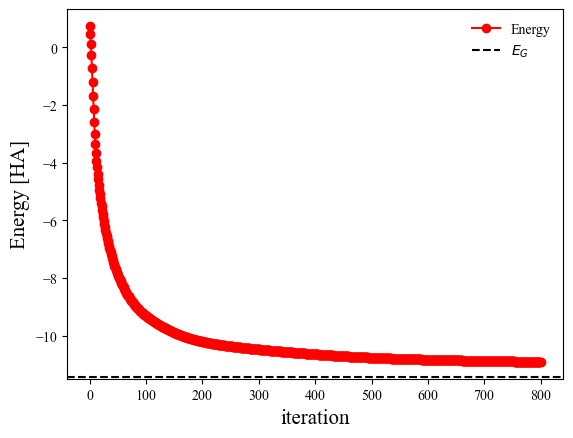

In [50]:
# p = 6 num of electrons = 6 

plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(energy_list, '-o', c= 'red', label ='Energy')
plt.axhline(y = E_g, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('Energy [HA]', fontsize = 15)
plt.legend(frameon=False)
# plt.plot(energy_list, '-o')
# plt.axhline(y = E_g, c = 'k', linestyle = '--')

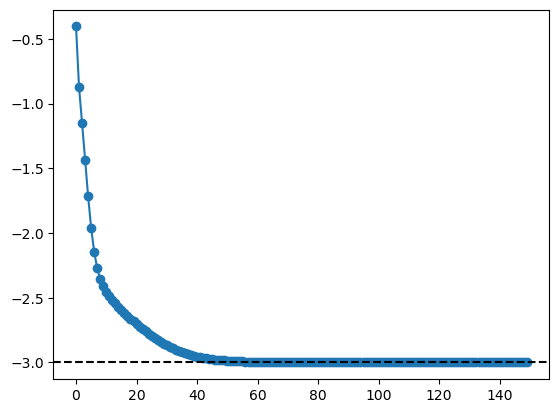

In [ ]:
# p = 6 num of electrons = 6 
plt.plot(energy_list, '-o')
plt.axhline(y = E_g, c = 'k', linestyle = '--')